In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Imports
import numpy as np
import tensorflow as tf

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
from operator import itemgetter
from sklearn.datasets import fetch_mldata

%matplotlib notebook

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### Configuration setup

In [4]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.33

### Download the MNIST dataset

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Q1: Fully connected Network with 5 hidden layers

Here we used 5 fully connected layer each with 1024 dimension. we used normal distribution for intializing weights and biases and used xavier intialization as standard deviation function. 

In [6]:
def xavierfunc(shape):
    return np.sqrt(2.0/sum(shape))

In [7]:
x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, 10]) # original

W1 = tf.Variable(tf.truncated_normal([784, 1024], stddev = xavierfunc([784, 1024]) ))
b1 = tf.Variable(tf.truncated_normal([1024], stddev = xavierfunc([1024]) ))

W2 = tf.Variable(tf.truncated_normal([1024, 1024], stddev = xavierfunc([1024, 1024]) ))
b2 = tf.Variable(tf.truncated_normal([1024], stddev = xavierfunc([1024]) ))

W3 = tf.Variable(tf.truncated_normal([1024, 1024], stddev = xavierfunc([1024, 1024]) ))
b3 = tf.Variable(tf.truncated_normal([1024], stddev = xavierfunc([1024]) ))

W4 = tf.Variable(tf.truncated_normal([1024, 1024], stddev = xavierfunc([1024, 1024]) ))
b4 = tf.Variable(tf.truncated_normal([1024], stddev = xavierfunc([1024]) ))

W5 = tf.Variable(tf.truncated_normal([1024, 10], stddev = xavierfunc([1024, 10]) ))
b5 = tf.Variable(tf.truncated_normal([10], stddev = xavierfunc([10]) ))

y1 = tf.nn.leaky_relu((x@W1) + b1)
y2 = tf.nn.leaky_relu((y1@W2) + b2)
y3 = tf.nn.leaky_relu((y2@W3) + b3)
y4 = tf.nn.leaky_relu((y3@W4) + b4)
y_pred = ((y4@W5) + b5 )# predicted

centropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=y_pred))
train_model = tf.train.AdamOptimizer().minimize(centropy)

In [8]:
sess = tf.InteractiveSession(config=config)
tf.global_variables_initializer().run()


In [22]:
# Train The model
for i in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(1000)
    sess.run(train_model, feed_dict={x: batch_xs, y_: batch_ys})

In [23]:
# Test trained model
correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print("Accuracy:",sess.run(accuracy, feed_dict={x: mnist.test.images,
                                      y_: mnist.test.labels}))

Accuracy: 0.9832


### Q3: Feed forward with 1000 samples

<IPython.core.display.Javascript object>


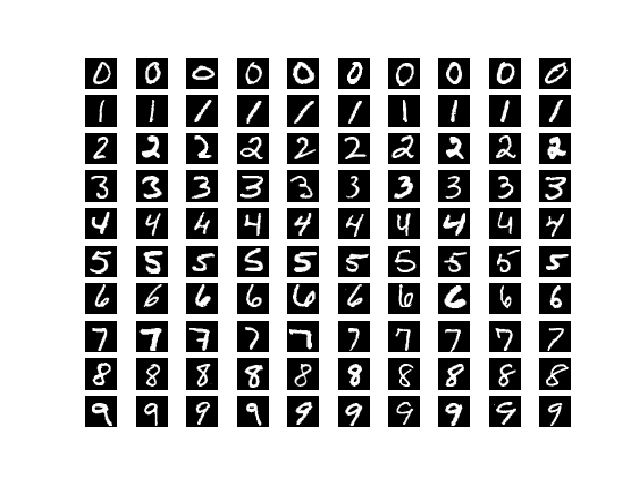

In [9]:
y_est = tf.nn.softmax(y_pred)
batch_xs, batch_ys = mnist.test.next_batch(1000)
y_np=sess.run(y_est, feed_dict={x: batch_xs})

diclabel={}

for r in range(1000):
    key = np.argmax(y_np[r])
    if key not in diclabel: 
        diclabel[key]=[]
        diclabel[key].append( (r, np.amax(y_np[r]) ) )
    else:
        diclabel[key].append( (r, np.amax(y_np[r]) ) )
for i in range(10):
    diclabel[i].sort(key=itemgetter(1),reverse=True)
    diclabel[i] = diclabel[i][0:10]                        
# print(diclabel)                      


## Plot the digits
%matplotlib notebook
plt.figure()
count=0
for k in range(10):
    r=0
    for val in diclabel[k]:
        plt.subplot(10,10,(count*10+r)+1)
        plt.imshow( batch_xs[int(val[0])].reshape((28,28)), cmap='gray')
        plt.axis('off')
        plt.show()
        r +=1
    count+=1

### Q4: Second  to  the  last  layeroutput

In question 3 we considered the top 10 images for each class to plot. The output layer of question 3 is the final output layer of the model and it has already learnt the pattern of MNIST digits where each output neuron in this layer represent to a single class. As the accuracy rate for our model is above 98% so it is really understandable that the output for each class will show the same 10 digits. 

On the other hand, in question 4 we choose 10 random neurons from the 1024 neurons of the 4th layer. In this layer the neurons are still trying to learn, so there is a chance their output may not be perfect. Though the chosen neurons are random it is not necessary that these 10 neurons will represent each of the 10 class. Also there could be possibility that the selected neuron from these 10 neurons maynot represent a class at all or get less then 10 images for a class after going through all the samples. Then we will get an empty line or less than 10 images for a class. And as this layer is still trying to learn the model so there is a high pobability that if there is other neuron learn a class better that the selected neuron but that neuron is not in the selected neuron list, then images from different class can activate same neuron.

In [10]:
random = np.random.choice(1024, size=10, replace=False)

<IPython.core.display.Javascript object>


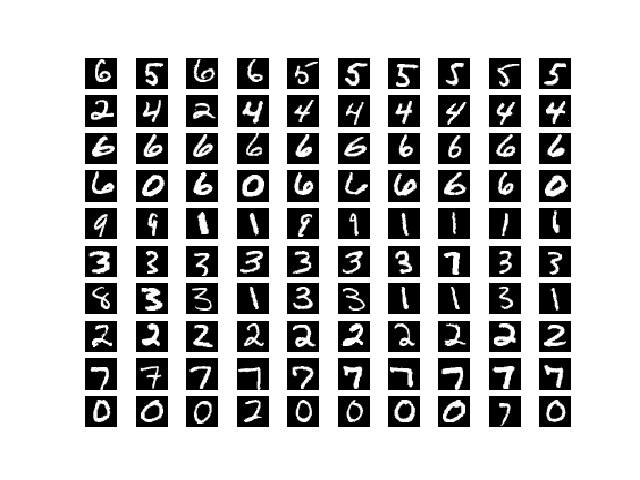

In [11]:
y_pred_4=sess.run(y4, feed_dict={x: batch_xs})
diclabel = {}
for r in range(1000):
    key = np.argmax(y_pred_4[r][random])
    if key not in diclabel: 
        diclabel[key]=[]
        diclabel[key].append( (r, np.amax(y_pred_4[r][random]) ) )
    else:
        diclabel[key].append( (r, np.amax(y_pred_4[r][random]) ) )
for i in range(10):
    if i not in diclabel:
        diclabel[i]=[]
    else:
        diclabel[i].sort(key=itemgetter(1),reverse=True)
        if len(diclabel[i]) > 10:
            diclabel[i] = diclabel[i][0:10]  
## Plot the digits
%matplotlib notebook
plt.figure()
count=0
for k in range(10):
    r=0
    for val in diclabel[k]:
        plt.subplot(10,10,(count*10+r)+1)
        plt.imshow( batch_xs[int(val[0])].reshape((28,28)), cmap='gray')
        plt.axis('off')
        plt.show()
        r +=1
    count+=1

### Q5: implementing tSNE and PCA

First using PCA, the dimension is minimized to 100. Then using tSNE the dimension is minimized to 2.

In [11]:
batch_xs, batch_ys = mnist.train.next_batch(1000)
batch_ys = np.argmax(batch_ys, axis=1)

In [12]:

pca100 = PCA(n_components=100)
pca_val = pca100.fit_transform(batch_xs)

# Then using tSNE, we minimize the dimention to 2
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_val)


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.003s...
[t-SNE] Computed neighbors for 1000 samples in 0.266s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.811078
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.941483
[t-SNE] Error after 300 iterations: 1.266140


### Q6: Apply tSNE and PCA and plot the data

Calculating mean of the each class. 

In [13]:
avg=[]
for k in range(10):
    zero=np.where(batch_ys == k)[0]
    avg.append(np.average(tsne_pca_results[zero], axis=0))
print(avg)

[array([15.16581  , -2.8987882], dtype=float32), array([ 4.85384 , 10.035088], dtype=float32), array([4.0107036, 3.2054343], dtype=float32), array([-0.1731849,  5.235305 ], dtype=float32), array([-11.250598 ,  -2.3883815], dtype=float32), array([-3.12357  ,  3.3039143], dtype=float32), array([ 6.665558 , -0.5183607], dtype=float32), array([-5.8688107, -6.1911063], dtype=float32), array([ 0.12765925, -2.3383782 ], dtype=float32), array([-9.080986, -4.798518], dtype=float32)]


Plot each class with different color.

<IPython.core.display.Javascript object>


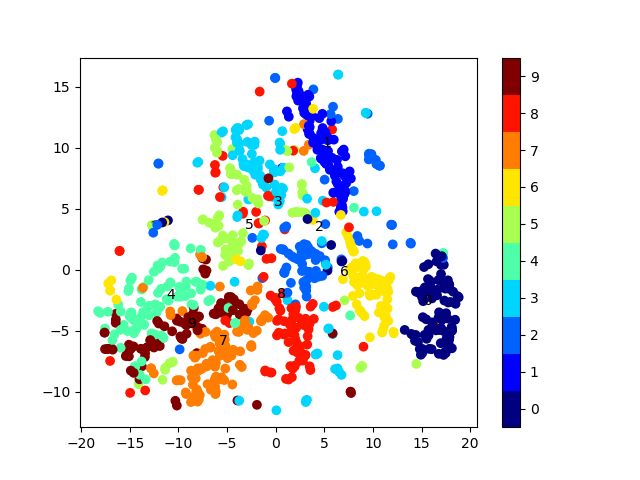

In [14]:
%matplotlib notebook
plt.figure()

plt.scatter(tsne_pca_results[:,0], tsne_pca_results[:,1], c=batch_ys, cmap=plt.cm.get_cmap("jet", 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)

for i in range(10):
    plt.annotate(i, (avg[i][0],avg[i][1]))

plt.show()

### Q7: For the first hidden layer

In this layer we applied tSNE and PCA on the 1024 output neurons of first hidden layer. Here we transform the input data into a 1024 dim space which will help us to better learn the data sample. In ques 6 we applied tSNE and PCA on raw data samples and the overlap between class is so much. So In this layer after adding the first layer we can observe a improvement into classification over the previous situation. 

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.258s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.534097
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.503899
[t-SNE] Error after 300 iterations: 0.941033


<IPython.core.display.Javascript object>


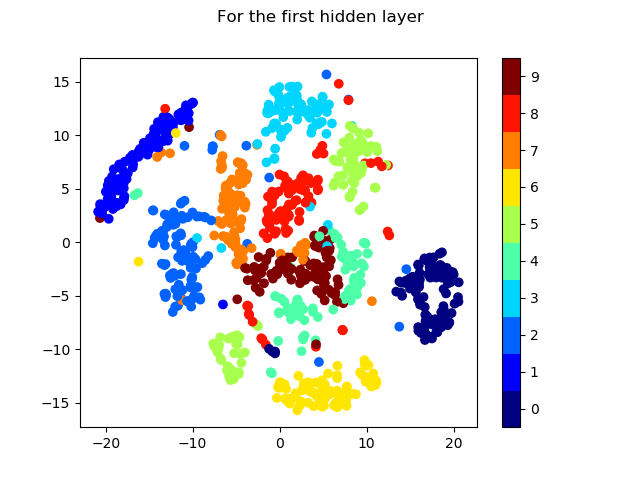

In [15]:
y_pred1 = tf.nn.softmax(y1)

# # Get a new train batch
batch_xs, batch_ys = mnist.test.next_batch(1000)

y_hidden1 =sess.run(y1, feed_dict={x: batch_xs})

batch_ys = np.argmax(batch_ys, axis=1)

pca_val = pca100.fit_transform(y_hidden1)

tsne_pca_results = tsne.fit_transform(pca_val)

## plot the data
%matplotlib notebook
plt.figure()
plt.suptitle('For the first hidden layer')
plt.scatter(tsne_pca_results[:,0], tsne_pca_results[:,1], c=batch_ys, cmap=plt.cm.get_cmap("jet", 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

### Q8: From second to last layer

Now we are applying the same tSNE and PCA on output of all the hidden layers (from second to the last layer) and observe their improvement in classifying the data samples. Here we can see that as we approach towards to the higher layer the data of same classes are clustering together. 

In [20]:
y_pred2 = tf.nn.softmax(y2)
y_pred3 = tf.nn.softmax(y3)
y_pred4 = tf.nn.softmax(y4)
y_pred5 = tf.nn.softmax(y_pred)

y_hd5,y_hd4,y_hd3,y_hd2 =sess.run([y_pred5,y4,y3,y2], 
                                          feed_dict={x: batch_xs})


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.004s...
[t-SNE] Computed neighbors for 1000 samples in 0.256s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 3.985229
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.018742
[t-SNE] Error after 300 iterations: 0.660651


<IPython.core.display.Javascript object>


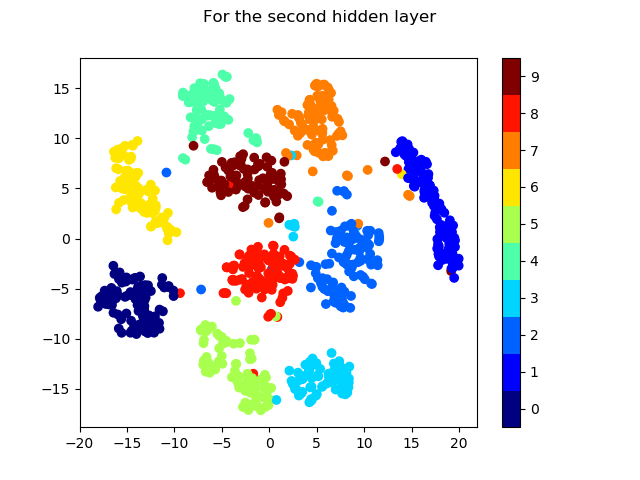

In [17]:
## For 2nd Layer
pca_val = pca100.fit_transform(y_hd2)
tsne_pca_results = tsne.fit_transform(pca_val)

%matplotlib notebook
plt.figure()
plt.suptitle('For the second hidden layer')
plt.scatter(tsne_pca_results[:,0], tsne_pca_results[:,1], c=batch_ys, cmap=plt.cm.get_cmap("jet", 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.003s...
[t-SNE] Computed neighbors for 1000 samples in 0.259s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 5.913238
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.543282
[t-SNE] Error after 300 iterations: 0.525660


<IPython.core.display.Javascript object>


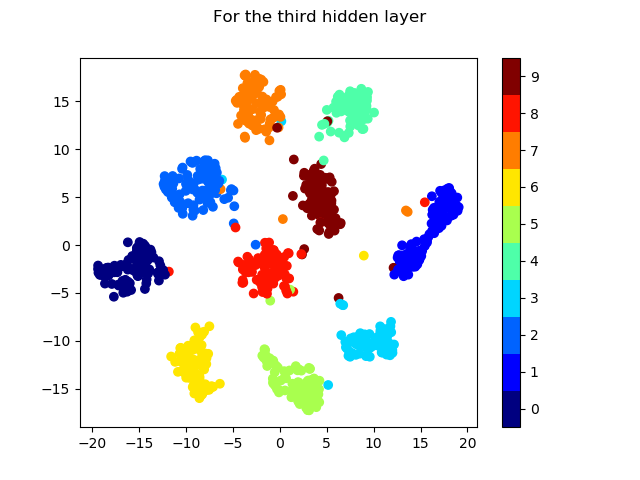

In [18]:
## For 3rd Layer
pca_val = pca100.fit_transform(y_hd3)
tsne_pca_results = tsne.fit_transform(pca_val)

%matplotlib notebook
plt.figure()
plt.suptitle('For the third hidden layer')
plt.scatter(tsne_pca_results[:,0], tsne_pca_results[:,1], c=batch_ys, cmap=plt.cm.get_cmap("jet", 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.237s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 7.957064
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.687294
[t-SNE] Error after 300 iterations: 0.479342


<IPython.core.display.Javascript object>


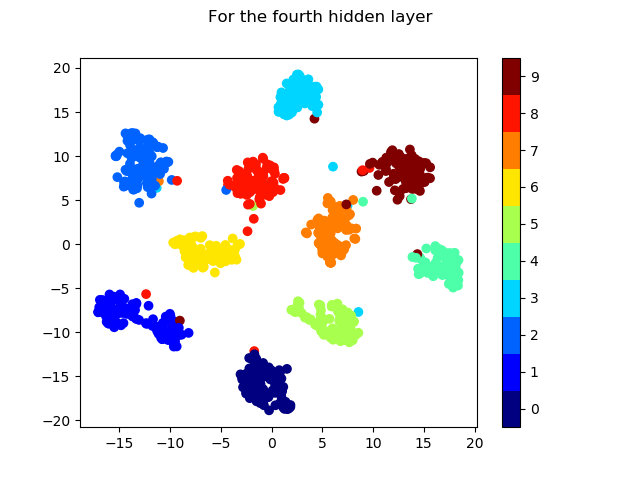

In [19]:
## For 4th Layer
pca_val = pca100.fit_transform(y_hd4)
tsne_pca_results = tsne.fit_transform(pca_val)

%matplotlib notebook
plt.figure()
plt.suptitle('For the fourth hidden layer')
plt.scatter(tsne_pca_results[:,0], tsne_pca_results[:,1], c=batch_ys, cmap=plt.cm.get_cmap("jet", 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.019s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 40.213799
[t-SNE] Error after 300 iterations: 0.283748


<IPython.core.display.Javascript object>


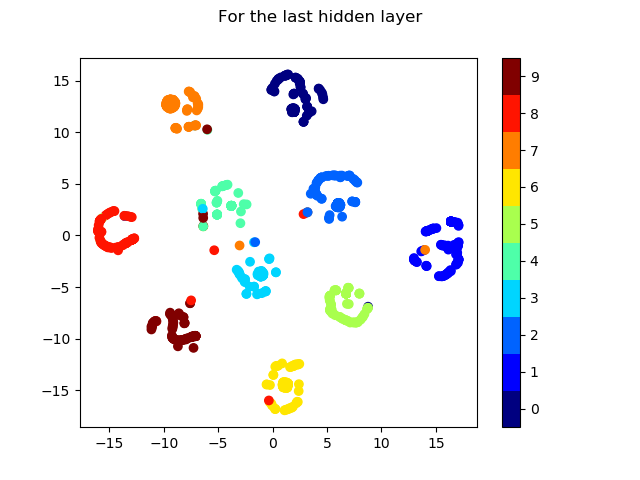

In [21]:
## For 5th Layer
pca5 = PCA(n_components=5)
pca_val = pca5.fit_transform(y_hd5)
tsne_pca_results = tsne.fit_transform(pca_val)

%matplotlib notebook
plt.figure()
plt.suptitle('For the last hidden layer')
plt.scatter(tsne_pca_results[:,0], tsne_pca_results[:,1], c=batch_ys, cmap=plt.cm.get_cmap("jet", 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()